In [1]:
import os
import time

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from PIL import Image

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tqdm import tqdm

### Metadata

In [2]:
meta = pd.read_csv("data/HAM10000_metadata.csv")
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# meta.loc[meta.image_id.isin(["ISIC_0029306", "ISIC_0029318", "ISIC_0029308", "ISIC_0029309"])]

### Link Metadata to Images

In [4]:
def get_image_path(image_id):
    if os.path.exists(os.path.join(image_dir_1, image_id + ".jpg")):
        return os.path.join(image_dir_1, image_id + ".jpg")
    elif os.path.exists(os.path.join(image_dir_2, image_id + ".jpg")):
        return os.path.join(image_dir_2, image_id + ".jpg")
    else:
        return None

In [5]:
image_dir_1 = "data/HAM10000_images_part_1/"
image_dir_2 = "data/HAM10000_images_part_2/"

df = meta
df["image_path"] = df["image_id"].apply(get_image_path)

missing_images = df[df["image_path"].isna()]
print(f"Missing images: {len(missing_images)}")

df.head()

Missing images: 0


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg


### Understand Class Distribution

- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (**akiec**), 
- basal cell carcinoma (**bcc**), 
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, (**bkl**), 
- dermatofibroma (**df**), 
- melanoma (**mel**), 
- melanocytic nevi (**nv**) and 
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, (**vasc**).

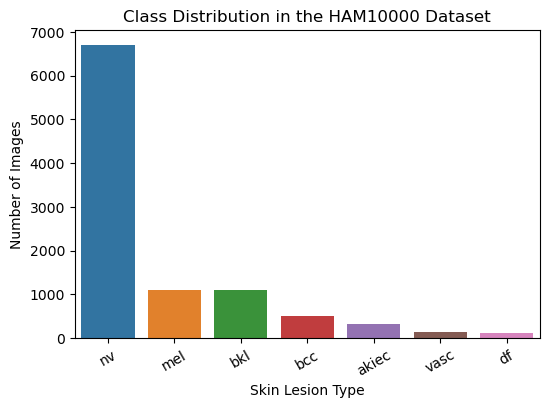

Class Distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [6]:
class_counts = df["dx"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="tab10")
plt.title("Class Distribution in the HAM10000 Dataset")
plt.xlabel("Skin Lesion Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)
plt.show()

print("Class Distribution:")
print(class_counts)

We'll have to factor in this during the modeling iterations and perhaps add a method to account for it.

### Data Preprocessing (Resizing & Normalising) and Splitting

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load image
        img_path = self.dataframe.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx]["dx"]

        label_map = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
        label_idx = label_map[label]

        return image, label_idx

In [9]:
# sub = df.sample(2000)
sub = df

unique_lesions = sub["lesion_id"].unique()
train_lesions, val_lesions = train_test_split(unique_lesions, test_size=0.2, random_state=42)
train_df = sub[sub["lesion_id"].isin(train_lesions)]
val_df = sub[sub["lesion_id"].isin(val_lesions)]

print(f"Train Set: {len(train_df)} images")
print(f"Validation Set: {len(val_df)} images")

Train Set: 7974 images
Validation Set: 2041 images


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [11]:
batch_size = 64
train_dataset = HAM10000Dataset(train_df, transform=transform)
val_dataset = HAM10000Dataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Using device: {device}")
print(f"Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Using device: mps
Train set size: 7974, Validation set size: 2041


### Model Selection and Training Setup

In [12]:
num_classes = 7
model = models.resnet34(pretrained=False)
# model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
class_counts = df["dx"].value_counts().sort_index()
total_samples = len(df)

class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Class Weights (Used in Loss Function):", class_weights)

Class Weights (Used in Loss Function): tensor([ 4.3753,  2.7835,  1.3018, 12.4410,  1.2855,  0.2134, 10.0755],
       device='mps:0')


In [14]:
optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
# optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.1)

### Model Training

In [15]:
def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy



def validate_model(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)

    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy



In [16]:
for images, labels in train_loader:
    print("Loaded a batch of images:", images.shape)
    break

Loaded a batch of images: torch.Size([64, 3, 224, 224])


In [17]:
patience = 3
no_improve_epochs = 0
num_epochs = 10
best_val_acc = 0.0
save_path = "best_renet34_10epochs_notpretrained.pth"

writer = SummaryWriter(log_dir="runs/HAM10000_resnet34_notpretrained")


for epoch in range(num_epochs):
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_model(model, train_loader, criterion, optimiser, device, epoch)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device, epoch)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("-" * 50)

    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

writer.close()
print("Training complete. Best validation accuracy:", best_val_acc)



Epoch 1/10



Epoch [1/10] - Time: 155.01s
Train Loss: 1.6854, Train Acc: 41.21%
Val Loss: 1.2314, Val Acc: 54.19%
--------------------------------------------------

Epoch 2/10



Epoch [2/10] - Time: 147.74s
Train Loss: 1.3892, Train Acc: 49.49%
Val Loss: 1.1406, Val Acc: 50.81%
--------------------------------------------------

Epoch 3/10



Epoch [3/10] - Time: 148.41s
Train Loss: 1.3034, Train Acc: 53.85%
Val Loss: 1.2984, Val Acc: 48.51%
--------------------------------------------------

Epoch 4/10



Epoch [4/10] - Time: 147.99s
Train Loss: 1.2440, Train Acc: 53.95%
Val Loss: 1.1069, Val Acc: 57.72%
--------------------------------------------------

Epoch 5/10



Epoch [5/10] - Time: 149.72s
Train Loss: 1.1793, Train Acc: 56.06%
Val Loss: 1.1137, Val Acc: 56.83%
--------------------------------------------------

Epoch 6/10



Epoch [6/10] - Time: 150.46s
Train Loss: 1.1305, Train Acc: 56.40%
Val Loss: 1.1568, Val Acc: 53.75%
--------------------------------------------------

Epoch 7/10



Epoch [7/10] - Time: 147.58s
Train Loss: 1.0993, Train Acc: 56.67%
Val Loss: 1.0352, Val Acc: 60.22%
--------------------------------------------------

Epoch 8/10



Epoch [8/10] - Time: 148.29s
Train Loss: 1.0502, Train Acc: 57.50%
Val Loss: 0.8922, Val Acc: 66.10%
--------------------------------------------------

Epoch 9/10



Epoch [9/10] - Time: 147.34s
Train Loss: 1.0146, Train Acc: 60.75%
Val Loss: 1.0410, Val Acc: 59.63%
--------------------------------------------------

Epoch 10/10



Epoch [10/10] - Time: 148.81s
Train Loss: 0.9873, Train Acc: 62.30%
Val Loss: 1.0661, Val Acc: 58.01%
--------------------------------------------------
Training complete. Best validation accuracy: 66.09505144536992


### Model Evaluation

In [18]:
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

def classification_report_df(true_labels, predicted_labels, class_names):
    report_dict = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    
    report_df = pd.DataFrame(report_dict).transpose()
    
    report_df = report_df.round(4)
    
    return report_df

In [19]:
true_labels, predicted_labels = evaluate_model(model, val_loader, device)

In [20]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
report_df = classification_report_df(true_labels, predicted_labels, class_names)
report_df

,precision,recall,f1-score,support
akiec,0.2683,0.3235,0.2933,68.0000
bcc,0.3895,0.5606,0.4596,132.0000
bkl,0.4525,0.5861,0.5107,244.0000
df,0.1130,0.3824,0.1745,34.0000
mel,0.2884,0.6756,0.4043,225.0000
nv,0.9713,0.5722,0.7202,1302.0000
vasc,0.6591,0.8056,0.7250,36.0000
accuracy,0.5772,0.5772,0.5772,0.5772
macro avg,0.4489,0.5580,0.4697,2041.0000
weighted avg,0.7532,0.5772,0.6202,2041.0000


In [21]:
report_df.to_csv("resnet34_10epochs_class_scores_notpretrained.csv")

### Inference - on the test set
- Not interested right now.

In [22]:
def predict_image(image_path, model, device):
    model.eval()
    
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
    
    class_map = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
    return class_map[predicted_class.item()]

In [23]:
image_path = "data/HAM10000_images_part_1/ISIC_0027419.jpg"
predicted_class = predict_image(image_path, model, device)
predicted_class

'akiec'

In [ ]:
# 15min runtime resnet18
# 62/5 epochs

In [ ]:
# 1k; bs 64 - 1m 48.4s
# 2k; bs 64 - 3m 56s